# Обзор рынка заведений общественного питания города Москва

Из открытых источников доступны данные о заведениях общественного питания в Москве. Для реализации проекта - небольшого оригинального проекта (кфае с официантами-роботами), необходимо изучить текущее положение дел на рынке.

Описание данных:<br>
Таблица rest_data:<br>
object_name — название объекта общественного питания;<br>
chain — сетевой ресторан;<br>
object_type — тип объекта общественного питания;<br>
address — адрес;<br>
number — количество посадочных мест.<br>

**Цель**: провести исследование рынка и сделать общий вывод/рекомендации о виде заведения, количестве посадочных мест, а также районе расположения потенциального кафе. Необходимо просмотреть данные, обработать пропуски.

## 1. Обзор и подготовка данных

In [1]:
#Библиотеки

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats
from io import BytesIO
import requests
import re
from itertools import chain

In [2]:
#Загрузка данных

rest_data = pd.read_csv('/datasets/rest_data.csv')

In [3]:
print('Кол-во дубликатов:',rest_data[['object_name','address','object_type']].duplicated().sum())

Кол-во дубликатов: 171


In [4]:
rest_data.isna().sum()

id             0
object_name    0
chain          0
object_type    0
address        0
number         0
dtype: int64

In [5]:
rest_data = rest_data.drop_duplicates(subset=['object_name','address','object_type']).reset_index(drop=True)

In [6]:
rest_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15195 entries, 0 to 15194
Data columns (total 6 columns):
id             15195 non-null int64
object_name    15195 non-null object
chain          15195 non-null object
object_type    15195 non-null object
address        15195 non-null object
number         15195 non-null int64
dtypes: int64(2), object(4)
memory usage: 712.4+ KB


В данных были обработаны дубликаты (столбец 'number' не учитывался, т.к. у одного заведения могло быть несколько вариантов посадочных мест, столбец 'chain' не учитывался т.к. заведение не может быть сетевым и несетевым одновременно), пропусков в данных нет.

## 2. Анализ данных

### 2.1. Исследование соотношения видов объектов общественного питания по количеству.

In [7]:
rest_data['object_type'].replace(['магазин (отдел кулинарии)', 'предприятие быстрого обслуживания'], ['магазин', 'ПБО']\
    , inplace=True) 

rest_by_object_type = rest_data.groupby('object_type').agg({'id':'count'}).sort_values(by='id', ascending=False)
rest_by_object_type['object_type'] = rest_by_object_type.index
rest_by_object_type = rest_by_object_type.rename(columns={'id':'count'})
rest_by_object_type = rest_by_object_type.reset_index(drop=True)
rest_by_object_type

,count,object_type
0,6017,кафе
1,2575,столовая
2,2275,ресторан
3,1891,ПБО
4,853,бар
5,571,буфет
6,393,кафетерий
7,348,закусочная
8,272,магазин


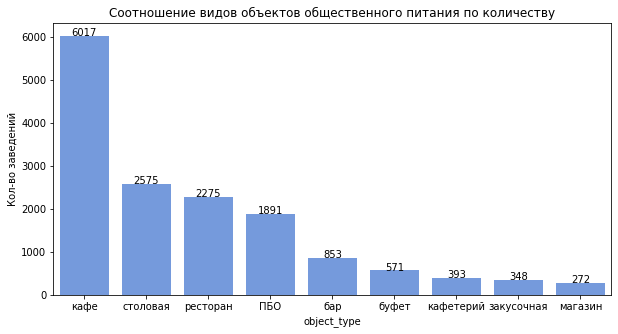

In [9]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(x='object_type',y='count',data=rest_by_object_type, color='cornflowerblue')
plt.title('Соотношение видов объектов общественного питания по количеству')
plt.ylabel('Кол-во заведений')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height, '{:1.0f}'.format(height), ha="center")

plt.show()

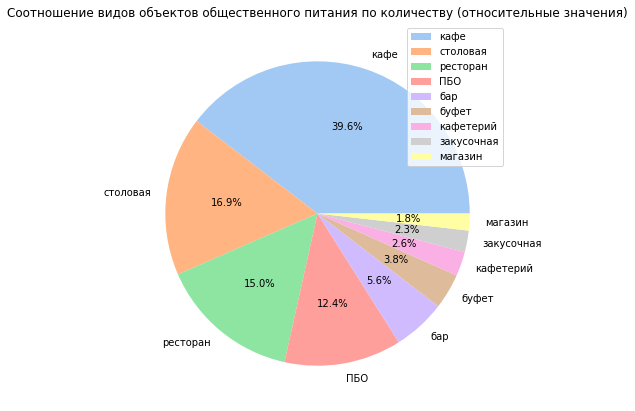

In [9]:
col = sns.color_palette("pastel", 9)
rest_by_object_type.set_index('object_type').plot(kind='pie',y='count', autopct='%1.1f%%',figsize=(7, 7),colors = col)
plt.legend(loc="upper right")
plt.title('Соотношение видов объектов общественного питания по количеству (относительные значения)')
plt.ylabel('')
plt.show()

Как видно из графика абсолютное преимущество у 'кафе' - данный вид объекта лидирует с большим отрывом. В четверку лучших также входят столовая, ресторан и предприятия быстрого обслуживания.

### 2.2. Исследование соотношение сетевых и несетевых заведений по количеству.

In [10]:
rest_by_chain = rest_data.groupby('chain').agg({'id':'count'}).sort_values(by='id', ascending=False)
rest_by_chain['chain'] = rest_by_chain.index
rest_by_chain = rest_by_chain.rename(columns={'id':'count'})
rest_by_chain = rest_by_chain.reset_index(drop=True)
rest_by_chain

,count,chain
0,12245,нет
1,2950,да


In [11]:
total_chain = int(rest_by_chain.query('chain=="да"')['count'])

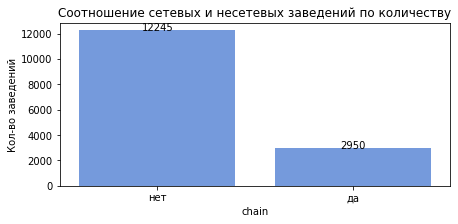

In [12]:
plt.figure(figsize=(7, 3))
ax = sns.barplot(x='chain',y='count',data=rest_by_chain, color='cornflowerblue')
plt.title('Соотношение сетевых и несетевых заведений по количеству')
plt.ylabel('Кол-во заведений')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height, '{:1.0f}'.format(height), ha="center")

plt.show()

Сетевых заведений в 4 раза меньше чем несетевых.

### 2.3. Сетевое распространение - для какого вида объектов характерно?

In [13]:
rest_by_object_type_with_chain = rest_data.query('chain=="да"')\
    .groupby('object_type').agg({'id':'count'}).sort_values(by='id', ascending=False)
rest_by_object_type_with_chain['object_type'] = rest_by_object_type_with_chain.index
rest_by_object_type_with_chain = rest_by_object_type_with_chain.rename(columns={'id':'count'})
rest_by_object_type_with_chain = rest_by_object_type_with_chain.reset_index(drop=True)
rest_by_object_type_with_chain = rest_by_object_type_with_chain.merge(rest_by_object_type, on='object_type')
rest_by_object_type_with_chain['percent'] = \
    rest_by_object_type_with_chain['count_x'] / rest_by_object_type_with_chain['count_y']*100
format = lambda x: '%.2f' % x
rest_by_object_type_with_chain['percent'] = rest_by_object_type_with_chain['percent'].map(format).astype(float)
rest_by_object_type_with_chain

,count_x,object_type,count_y,percent
0,1389,кафе,6017,23.08
1,784,ПБО,1891,41.46
2,541,ресторан,2275,23.78
3,78,магазин,272,28.68
4,56,закусочная,348,16.09
5,51,кафетерий,393,12.98
6,37,бар,853,4.34
7,11,буфет,571,1.93
8,3,столовая,2575,0.12


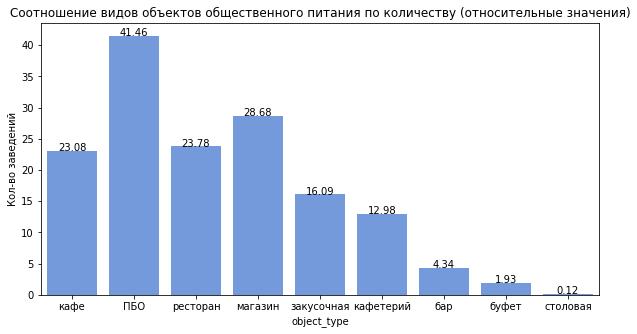

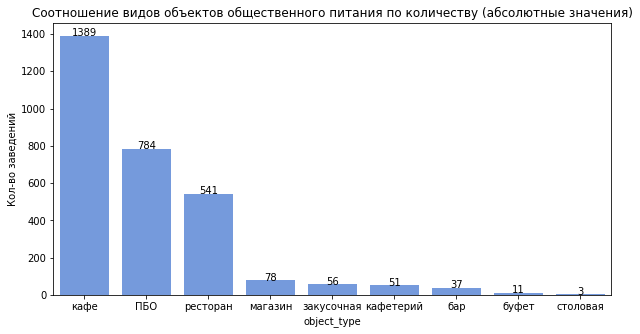

In [14]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(x='object_type',y='percent',data=rest_by_object_type_with_chain, color='cornflowerblue')
plt.title('Соотношение видов объектов общественного питания по количеству (относительные значения)')
plt.ylabel('Кол-во заведений')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height, '{:1.2f}'.format(height), ha="center")

plt.show()

plt.figure(figsize=(10, 5))
ax2 = sns.barplot(x='object_type',y='count_x',data=rest_by_object_type_with_chain, color='cornflowerblue')
plt.title('Соотношение видов объектов общественного питания по количеству (абсолютные значения)')
plt.ylabel('Кол-во заведений')

for p in ax2.patches:
    height = p.get_height()
    ax2.text(p.get_x()+p.get_width()/2., height, '{:1.0f}'.format(height), ha="center")

plt.show()

Половина всех сетевых заведений - кафе, 25% - предприятия быстрого обслуживания. В относительных величинах лидиуют предприятия быстрого обслуживания - 41% таких заведений являются сетевыми, далее идут магазины, рестораны и кафе (28%, 25% и 23% соответственно).

### 2.4. Что характерно для сетевых заведений?

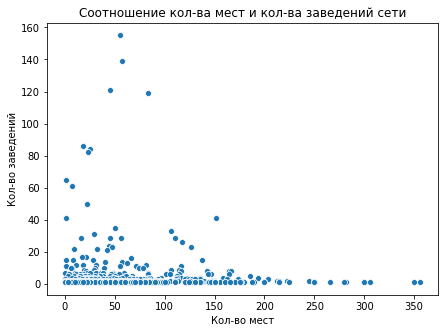

In [15]:
#создадим сводную таблицу сетевых заведений со средник кол-вом мест разбитых по названиям
chain_number = rest_data.query('chain=="да"').groupby('object_name').agg({'object_name' : 'count','number' : 'mean'})
chain_number = chain_number.rename(columns={'object_name':'count'}).sort_values(by='count', ascending=False)

plt.figure(figsize=(7, 5))
sns.scatterplot(x='number',y='count',data=chain_number)
plt.title('Соотношение кол-ва мест и кол-ва заведений сети')
plt.xlabel('Кол-во мест')
plt.ylabel('Кол-во заведений')
plt.show()

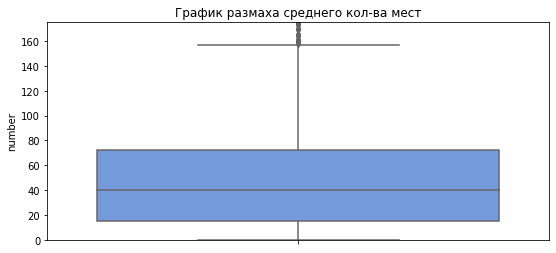

In [16]:
plt.figure(figsize=(9, 4))
sns.boxplot(y='number',data=rest_data.query('chain=="да"'), color='cornflowerblue')
plt.title('График размаха среднего кол-ва мест')
plt.ylim(0,175)
plt.show()

In [17]:
rest_data.query('chain=="да"').describe()

,id,number
count,2950.000000,2950.000000
mean,118053.417288,53.009153
std,67479.828639,57.214495
min,838.000000,0.000000
25%,59196.750000,15.000000
50%,129890.000000,40.000000
75%,176700.750000,72.000000
max,223318.000000,580.000000


Большинство сетей имеет до 20 заведений и до 160 мест  посадочных мест (зачения выше 160 - выбросы, согласно диаграмме размаха).

### 2.5. Среднее количество посадочных мест для каждого вида объекта общественного питания.

In [18]:
object_type_number = rest_data.groupby('object_type').agg({'object_type' : 'count','number' : 'mean'})
object_type_number = object_type_number.rename(columns={'object_type':'count'}).sort_values(by='count', ascending=False)
object_type_number

,count,number
object_type,,
кафе,6017,39.875187
столовая,2575,130.367767
ресторан,2275,97.047473
ПБО,1891,20.786885
бар,853,43.602579
буфет,571,51.572680
кафетерий,393,9.221374
закусочная,348,7.663793
магазин,272,5.610294


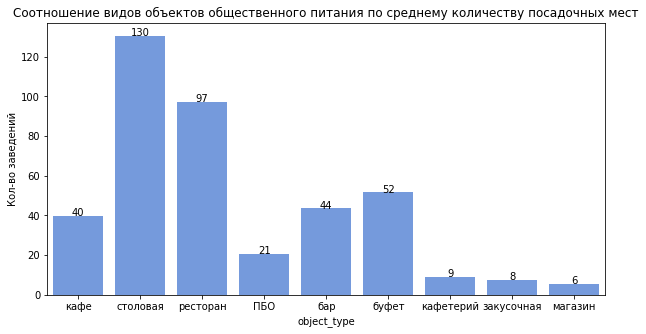

In [19]:
plt.figure(figsize=(10, 5))
ax=sns.barplot(x=object_type_number.index,y='number',data=object_type_number, color='cornflowerblue')
plt.title('Соотношение видов объектов общественного питания по среднему количеству посадочных мест')
plt.ylabel('Кол-во заведений')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height, '{:1.0f}'.format(height), ha="center")

plt.show()

В среднем у столовых самое большое кол-во посадочных мест (130), далее идут рестораны (97) и буфеты (52). Замыкают пятерку лидеров бары (44) и кафе (40).

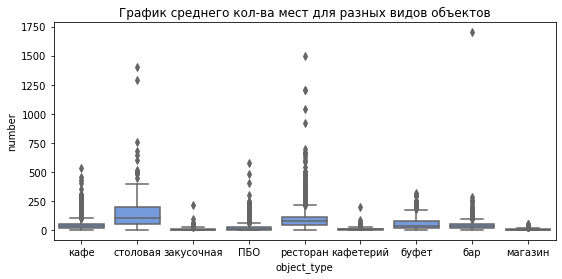

In [20]:
plt.figure(figsize=(9, 4))
sns.boxplot(x='object_type',y='number',data=rest_data, color='cornflowerblue')
plt.title('График среднего кол-ва мест для разных видов объектов')
plt.show()

В данных присутствуют выбросы, но они не сильно влияют на результаты исследования (при расчете медианы лидирующие позиции остаются у тех же типов объектов).

### 2.6. Выделяем в отдельный столбец информацию об улице из столбца 'address'

In [21]:
#выделение стлобца улицы из общего адреса
rest_data['split_address'] = rest_data['address'].str.split(', ')

def street_name(row):
    x = row['split_address'][1]
    return x
rest_data['street'] = rest_data.apply(street_name, axis=1)

#ищем значения 'дом' и 'город' в улицах
def search(row):
    home = re.search('дом$|^дом',row['street'])
    town = re.search('город$|^город',row['street'])
    if home == None:
        if town == None:
            return 'ok'
        else:
            return 'town'
    else:
        return 'house'
rest_data['house_or_town'] = rest_data.apply(search, axis=1)
#указываем улицу в зависимости от значения 'street'
def street_name(row):
    if row['house_or_town']=='house':
        x = row['split_address'][0]
    else:
        if row['house_or_town']=='town':
            x = row['split_address'][2]
        else:
            x = row['split_address'][1]
    return x
rest_data['street'] = rest_data.apply(street_name, axis=1)
rest_data = rest_data.drop('house_or_town', axis=1)

In [22]:
#поиск улиц в столбце street и замена пропусков на значение 'unknown_street'
rest_data['search_street'] = rest_data['street']\
.apply(lambda x :re.search('шоссе|улица|переулок|проезд|проспект|тупик|километр|набережная|бульвар|площадь|квартал|аллея|линия|микрорайон',str(x)))

rest_data.loc[rest_data['search_street']!=rest_data['search_street'],'street'] = 'unknown_street'
rest_data = rest_data.drop('split_address', axis=1)
rest_data = rest_data.drop('search_street', axis=1)

### 2.7. Топ-10 улиц по количеству объектов общественного питания.

In [23]:
rest_by_street = rest_data.groupby('street').agg({'street':'count'})
rest_by_street = rest_by_street.rename(columns={'street':'count'})
rest_by_street['street'] = rest_by_street.index
rest_by_street = rest_by_street.reset_index(drop=True)
#удалим города и поселки из топ10 - будем рассматривать только заведения в пределах города Москвы
rest_by_street_top10 = rest_by_street.query('street!="unknown_street"')\
    .sort_values(by='count', ascending=False).head(10)
rest_by_street_top10

,count,street
1423,197,проспект Мира
1020,181,Профсоюзная улица
698,172,Ленинградский проспект
1004,165,Пресненская набережная
415,162,Варшавское шоссе
701,147,Ленинский проспект
1419,127,проспект Вернадского
689,114,Кутузовский проспект
613,110,Каширское шоссе
619,107,Кировоградская улица


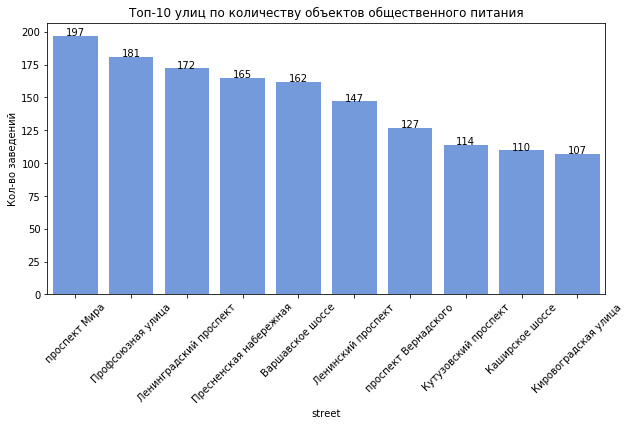

In [24]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(x='street',y='count',data=rest_by_street_top10, color='cornflowerblue')
plt.title('Топ-10 улиц по количеству объектов общественного питания')
plt.ylabel('Кол-во заведений')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height, '{:1.0f}'.format(height), ha="center")
plt.xticks(rotation=45)
plt.show()

### 2.8. Число улиц с одним объектом общественного питания. В каких районах Москвы находятся эти улицы?

In [25]:
#соотношение улиц с районами города Москва
#информация взята с официального сайта Правительства Москвы
#https://data.mos.ru/

spreadsheet_id = '1snL1ddI0yT-xZYr0_MCB614Gz_Rz-fl55VR9GOJm7AQ'
file_name = 'https://docs.google.com/spreadsheets/d/1snL1ddI0yT-xZYr0_MCB614Gz_Rz-fl55VR9GOJm7AQ/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
street_data = pd.read_csv(BytesIO(r.content))
street_data = street_data.drop(['UM_CODE','global_id','UM_NAMES','UM_TRANS','UM_TM','UM_KLADR','UM_TYPE'], axis=1)
street_data = street_data.query('UM_TE!="UM_TE"').rename(columns={'UM_NAMEF':'street','UM_TE':'code'})

#парсер столбца code на отдельные строки
def chainer(s):
    return list(chain.from_iterable(s.str.split(';')))
lens = street_data['code'].str.split(';').map(len)
street_data_full = pd.DataFrame({'street': np.repeat(street_data['street'], lens),
                    'code': chainer(street_data['code'])})
street_data_full['code'] = street_data_full['code'].astype(int)

In [26]:
spreadsheet_id = '1m5hjZ9UPvWzC_vOOnw8Kmz3CD-rmDz4fyxiXAK2lN7E'
file_name = 'https://docs.google.com/spreadsheets/d/1m5hjZ9UPvWzC_vOOnw8Kmz3CD-rmDz4fyxiXAK2lN7E/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
district_data = pd.read_csv(BytesIO(r.content))
district_data = district_data.drop(['global_id','Latin_name','Type','Kod_okato'], axis=1)
district_data = district_data.rename(columns={'Kod':'code','Name':'district'})

street_by_district = street_data_full.merge(district_data, on='code')

In [27]:
top10_street_with_code = rest_by_street_top10.merge(street_by_district, on='street',how='left')

In [28]:
all_district = rest_data.merge(street_by_district, on='street',how='left')
all_district['district'].value_counts()

Тверской район                   1119
поселение Первомайское           1082
Пресненский район                 792
поселение Марушкинское            709
Басманный район                   695
                                 ... 
район Силино                       27
поселение Кленовское               22
поселение Михайлово-Ярцевское      17
район Капотня                      16
район Восточный                     3
Name: district, Length: 143, dtype: int64

Самый популярный районами (по кол-ву заведений) - Тверской. В нем находится 1119 заведений.

In [29]:
top10_distr = (top10_street_with_code.groupby(['district']).agg({'count': 'sum'})
.sort_values(by='count',ascending=False))  

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:203: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  "'colors' is being deprecated. Please use 'color'"


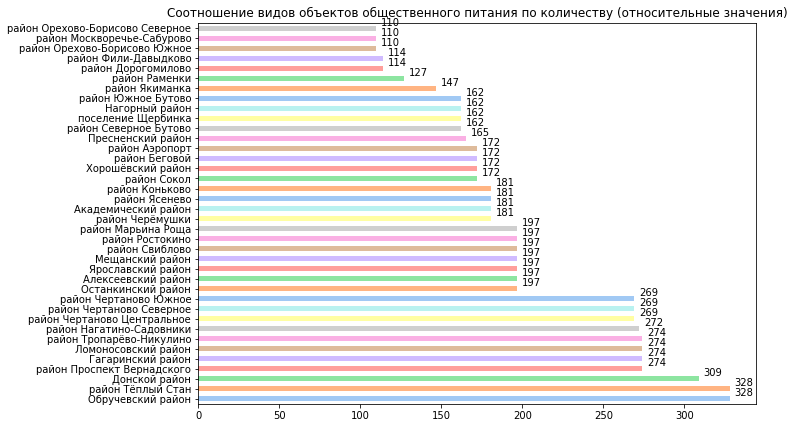

In [37]:
col = sns.color_palette("pastel", 10)
ax = top10_distr.plot(kind='barh',y='count',figsize=(10, 7), colors=col)

for i, v in enumerate(top10_distr['count']):
    ax.text(v + 3, i + .25, str(v))

plt.legend().set_visible(False)
plt.title('Соотношение видов объектов общественного питания по количеству (относительные значения)')
plt.ylabel('')
plt.show()

Самые популярные районы в которые входят топ-10 улиц (по кол-ву заведений) - Обручевский и Теплый Стан. В них находятся 328 заведений (пересекаются 2 улицы из топ-10).

In [31]:
one_rest_streets = rest_by_street.query('count==1')
one_rest_streets_with_code = one_rest_streets.merge(street_by_district, on='street')
print('Список районов Москвы, в которых присутствуют улицы с одним объектом общественного питания:'\
      ,one_rest_streets_with_code['district'].unique())
print('Кол-во уникальных районов списка:',len(one_rest_streets_with_code['district'].unique()))

Список районов Москвы, в которых присутствуют улицы с одним объектом общественного питания: ['район Аэропорт' 'Басманный район' 'Красносельский район'
 'район Свиблово' 'Рязанский район' 'район Якиманка'
 'поселение Новофедоровское' 'район Хамовники' 'район Соколиная Гора'
 'Даниловский район' 'Мещанский район' 'Таганский район' 'район Лефортово'
 'район Печатники' 'район Замоскворечье' 'Хорошёвский район' 'район Арбат'
 'Алексеевский район' 'район Текстильщики' 'район Ростокино'
 'район Раменки' 'район Хорошёво-Мнёвники' 'район Покровское-Стрешнево'
 'район Марьина Роща' 'район Сокольники' 'район Богородское'
 'Нижегородский район' 'Тверской район' 'Лосиноостровский район'
 'район Преображенское' 'район Ново-Переделкино' 'район Гольяново'
 'район Северное Измайлово' 'район Измайлово' 'район Восточное Измайлово'
 'район Беговой' 'Донской район' 'Войковский район' 'Савёловский район'
 'поселение Щербинка' 'район Филёвский Парк' 'район Перово'
 'район Бирюлёво Восточное' 'район Чертаново

In [32]:
top10_and_one_rest_districts = list(set(top10_street_with_code['district']) & set(one_rest_streets_with_code['district']))
top10_and_one_rest_districts_difference = list(set(top10_street_with_code['district']) ^ set(top10_and_one_rest_districts))
print('Совпадения районов из списка "единичек" и топ10:',top10_and_one_rest_districts)
print('-------------------------------')
print('Разница списков:',top10_and_one_rest_districts_difference)

Совпадения районов из списка "единичек" и топ10: ['район Фили-Давыдково', 'Ярославский район', 'Обручевский район', 'Останкинский район', 'район Южное Бутово', 'район Черёмушки', 'Гагаринский район', 'район Коньково', 'район Якиманка', 'район Свиблово', 'Хорошёвский район', 'район Чертаново Северное', 'район Чертаново Южное', 'район Москворечье-Сабурово', 'район Северное Бутово', 'Нагорный район', 'район Нагатино-Садовники', 'район Беговой', 'поселение Щербинка', 'Мещанский район', 'район Раменки', 'район Дорогомилово', 'Пресненский район', 'Донской район', 'район Аэропорт', 'район Ростокино', 'Алексеевский район', 'район Тёплый Стан', 'район Ясенево', 'район Сокол', 'район Марьина Роща']
-------------------------------
Разница списков: ['район Орехово-Борисово Северное', 'Ломоносовский район', 'Академический район', 'район Чертаново Центральное', 'район Проспект Вернадского', 'район Орехово-Борисово Южное', 'район Тропарёво-Никулино']


### 2.9. Распределение количества посадочных мест для улиц с большим количеством объектов общественного питания.

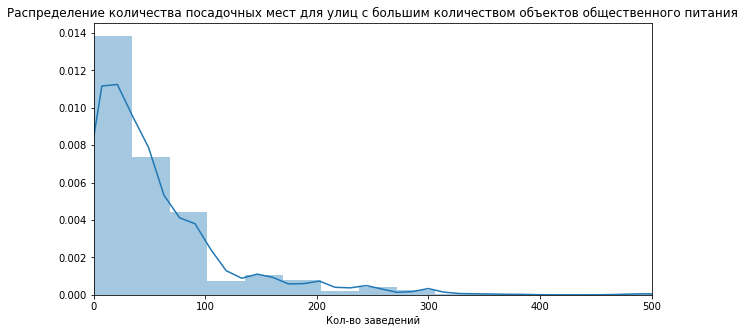

In [33]:
#полный список заведений по топ10 улицам (для графика с распределением)
top_steets_data = rest_data.loc[rest_data['street'].isin(rest_by_street_top10['street'])]

plt.figure(figsize=(10, 5))
sns.distplot(top_steets_data['number'])

plt.title('Распределение количества посадочных мест для улиц с большим количеством объектов общественного питания')
plt.xlim(0,500)
plt.xlabel('Кол-во заведений')
plt.show()

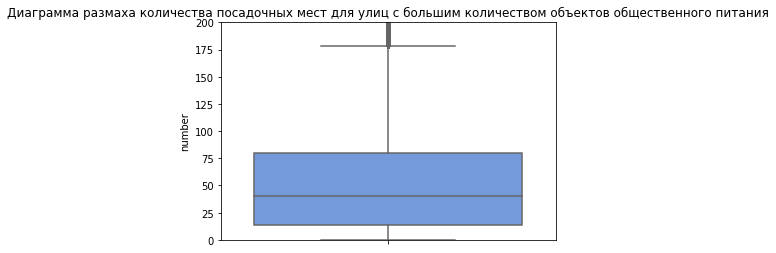

In [34]:
plt.title('Диаграмма размаха количества посадочных мест для улиц с большим количеством объектов общественного питания')
sns.boxplot(y='number',data=rest_data, color='cornflowerblue')
plt.ylim(0,200)
plt.show()

In [35]:
top_steets_data.describe()

,id,number
count,1482.000000,1482.000000
mean,126420.147099,58.387314
std,72250.621792,90.517313
min,19654.000000,0.000000
25%,29386.750000,12.000000
50%,150323.000000,40.000000
75%,188426.750000,75.000000
max,223439.000000,1700.000000


Распределение не нормальное, график скошен в право, медианное значение 40 посадочных мест. Выбросы - значения выше 175 посадочных мест. Такие значения наблюдались ранее у типов кафе, бар и буфет, видимо, на этих улицах высокая концентрация таких заведений.

# 3. Общий вывод

В рамках исследования были рассмотрены данные о заведениях общественного питания Москвы.

Были обработаны дубликаты заведений - найдены совпадения по именам, адресам заведений и типам объектов.
Пропусков в данных не обнаружено.

Самый популярный вид заведений в Москве относятся к сегменту "кафе" (более 40% от общего числа всех заведений).

Несетевых заведений 12245, сетевых - 2950 (практически в 4 раза меньше).

В рамках обзора сетевых заведений тип "кафе" так же лидирует в абсолютных значениях (1389), но в относительный значениях самый большой пул сетевых заведений у пунктов быстрого обслуживания (фастфуд) - 41% (у кафе 23%).

Большинство сетевых заведений имеет около 20 точек и до 160 посадочных мест.

Среднее кол-во мест для разных типов объектов варьируется от 6 (магазин) до 130 (столовая), у кафе среднее значение около 40 мест.

Топ-10 улиц по кол-ву заведений:
проспект Мира
Профсоюзная улица
Ленинградский проспект
Пресненская набережная
Варшавское шоссе
Ленинский проспект
проспект Вернадского
Кутузовский проспект
Каширское шоссе
Кировоградская улица

Самый популярный район (наибольшее кол-во заведений) - Тверской (1119 заведений).

Самые популярные районы в которые входят топ-10 улиц (по кол-ву заведений) - Обручевский и Теплый Стан. В них находятся 328 заведений (пересекаются 2 улицы из топ-10).

Среднее значение посадочных мест в заведениях на топ-10 популярных улиц находится в районе 40шт.

На улицах в которых присутствует только одно заведение открывать кафе нерентабельно - скорее всего, это место с малой проходимостью.
Стоит обратить внимание на следующие районы : 
Академический район
район Чертаново Центральное
район Орехово-Борисово Южное
район Орехово-Борисово Северное
район Тропарёво-Никулино
Ломоносовский район
район Проспект Вернадского

В этих районах расположены только улицы с высокой концентрацией потребителей (отсутствуют улицы с одним заведением).

Рекомендуется организовать ПБО или кафе сетевого типа, т.к. роботы не пригодны для обслуживания требовательных посетителей и могут справляться только с определенным перечнем задач. Кол-во посадочных мест можно установить в районе ~40.